**Nama : Muhammad Ramadhan Nafis Athaya<br>
Nim : 23.11.5873<br>
Kelas : 23S1IF-BigData5<br>
Topik : Optimasi Deteksi Website Phishing Menggunakan Hybrid Feature Selection dan Stacking Ensemble Learning<br>
Link Kaggle : https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls<br>
Link Colab : https://colab.research.google.com/drive/13-Nq_MZB_VT333eYPLGWTZOTbMtcS_Nx?usp=sharing**

# STEP 1: DATA ACQUISITION

- Upload dataset

In [1]:
import os
from google.colab import files

# 1. Konfigurasi Token Kaggle (Jika belum ada)
if not os.path.exists('kaggle.json'):
    print("Silakan upload file 'kaggle.json' Anda:")
    files.upload()

    # Pindahkan dan beri hak akses
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Token Kaggle berhasil dikonfigurasi.")
else:
    print("Token Kaggle sudah tersedia.")

# 2. Download Dataset Baru (taruntiwarihp/phishing-site-urls)
print("\n⬇Sedang mendownload dataset 'Phishing Site URLs'...")
!kaggle datasets download -d taruntiwarihp/phishing-site-urls --force

# 3. Ekstrak File ZIP
print("Mengekstrak dataset...")
!unzip -o -q phishing-site-urls.zip

print("\nData mentah siap digunakan.")

Silakan upload file 'kaggle.json' Anda:


Saving kaggle.json to kaggle.json
Token Kaggle berhasil dikonfigurasi.

⬇Sedang mendownload dataset 'Phishing Site URLs'...
Dataset URL: https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls
License(s): DbCL-1.0
  0% 0.00/9.03M [00:00<?, ?B/s]
100% 9.03M/9.03M [00:00<00:00, 1.25GB/s]
Mengekstrak dataset...

Data mentah siap digunakan.


- Melihat isi dataset

In [2]:
import pandas as pd

# Load dataset baru
filename = 'phishing_site_urls.csv'
df = pd.read_csv(filename)

print(f"Membaca file: {filename}")
print(f"Jumlah Baris (Total URL): {df.shape[0]}")
print(f"Jumlah Kolom: {df.shape[1]}")

# Intip isinya (Harusnya cuma teks aneh-aneh)
print("\n5 Data Teratas:")
display(df.head())

Membaca file: phishing_site_urls.csv
Jumlah Baris (Total URL): 549346
Jumlah Kolom: 2

5 Data Teratas:


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


- Cek tipe data setiap kolom

In [3]:
print("ℹStruktur Dataset:")
df.info()

ℹStruktur Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


- Cek statistik dataset

In [4]:
print("Statistik Data Teks:")
# include='object' memaksa pandas menganalisa kolom teks
display(df.describe(include='object').transpose())

Statistik Data Teks:


,count,unique,top,freq
URL,549346,507195,jhomitevd2abj3fk.onion.to/,52
Label,549346,2,good,392924


- Cek missing value

In [5]:
# 1. Cek Data Kosong
jumlah_kosong = df.isnull().sum().sum()
print(f"Jumlah Data Kosong (NaN): {jumlah_kosong}")

# 2. Cek Data Kembar (Duplikat)
jumlah_duplikat = df.duplicated().sum()
print(f"Jumlah Data Duplikat   : {jumlah_duplikat}")

if jumlah_duplikat > 0:
    print(f"\nPERINGATAN: Ada {jumlah_duplikat} data yang sama persis!")
    print("   Saran: Nanti di langkah cleaning harus dihapus agar akurasi valid.")

Jumlah Data Kosong (NaN): 0
Jumlah Data Duplikat   : 42150

PERINGATAN: Ada 42150 data yang sama persis!
   Saran: Nanti di langkah cleaning harus dihapus agar akurasi valid.


- Cek distribusi kelas

Menghitung Keseimbangan Kelas 'Label'...
Label
good    392924
bad     156422
Name: count, dtype: int64


/tmp/ipython-input-2408262023.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=target_col, data=df, palette='viridis')


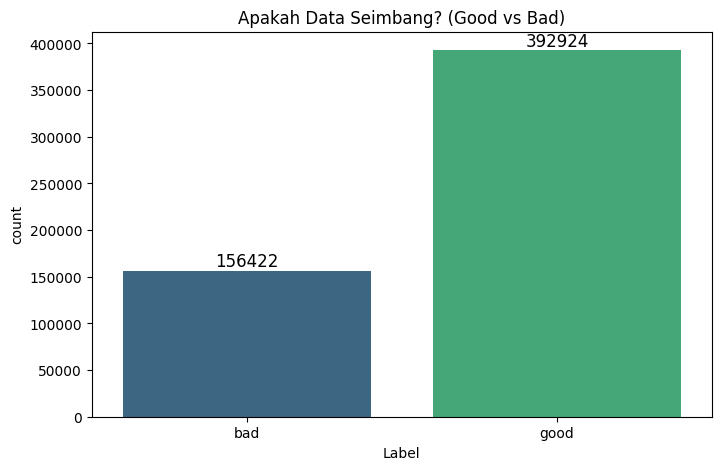

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

target_col = 'Label' # Nama kolom di dataset Tarun Tiwari biasanya 'Label' (Huruf L besar)

print(f"Menghitung Keseimbangan Kelas '{target_col}'...")
print(df[target_col].value_counts())

# Visualisasi
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=target_col, data=df, palette='viridis')

# Tambahkan angka di atas batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.title('Apakah Data Seimbang? (Good vs Bad)')
plt.show()

# STEP 2: PREPROCESSING DATA

- Menghapus data duplikat

In [7]:
print("Sedang memeriksa duplikat...")

# 1. Cek Kondisi Awal
jumlah_awal = df.shape[0]
jumlah_duplikat = df.duplicated().sum()

print(f"Jumlah Data Awal     : {jumlah_awal}")
print(f"Ditemukan Duplikat   : {jumlah_duplikat} baris")

# 2. Eksekusi Penghapusan
if jumlah_duplikat > 0:
    df.drop_duplicates(inplace=True)

    # Reset Index (Penting! Agar nomor baris urut kembali dari 0, 1, 2, ...)
    df.reset_index(drop=True, inplace=True)

    jumlah_akhir = df.shape[0]
    print(f"Duplikat dihapus.")
    print(f"Jumlah Data Akhir    : {jumlah_akhir} (Steril)")
else:
    print("Data sudah bersih, tidak ada duplikat.")

Sedang memeriksa duplikat...
Jumlah Data Awal     : 549346
Ditemukan Duplikat   : 42150 baris
Duplikat dihapus.
Jumlah Data Akhir    : 507196 (Steril)


- Menghapus missing value

In [8]:
print("Sedang memeriksa data kosong (NaN)...")

# 1. Cek Kondisi Awal
jumlah_kosong = df.isnull().sum().sum()
print(f"Ditemukan Data Kosong : {jumlah_kosong} sel")

# 2. Eksekusi Penghapusan
if jumlah_kosong > 0:
    df.dropna(inplace=True)

    # Reset Index lagi biar rapi
    df.reset_index(drop=True, inplace=True)

    print(f"Data kosong berhasil dibuang.")
else:
    print("Data sudah lengkap, tidak ada yang kosong.")

# Cek dimensi akhir untuk memastikan
print(f"Sisa Data Siap Pakai  : {df.shape[0]} Baris")

Sedang memeriksa data kosong (NaN)...
Ditemukan Data Kosong : 0 sel
Data sudah lengkap, tidak ada yang kosong.
Sisa Data Siap Pakai  : 507196 Baris


- Label encoding (ubah jadi 0 dan 1)

In [9]:
print("Mengubah Label Teks menjadi Angka...")

# 1. Cek Label Asli
print(f"Label Asli : {df['Label'].unique()}")

# 2. Mapping Manual (Agar konsisten: Bad/Phishing = 1)
label_mapping = {'bad': 1, 'good': 0}
df['Label'] = df['Label'].map(label_mapping)

# 3. Verifikasi Hasil
print(f"Label Baru : {df['Label'].unique()} (0=Aman, 1=Phishing)")
print("Encoding Selesai.")

Mengubah Label Teks menjadi Angka...
Label Asli : ['bad' 'good']
Label Baru : [1 0] (0=Aman, 1=Phishing)
Encoding Selesai.


- Feature engineering

In [10]:
from urllib.parse import urlparse

def ekstrak_fitur_url(url):
    url = str(url)
    fitur = {}

    # Parsing struktur URL
    try:
        parsed = urlparse(url)
        hostname = parsed.netloc
        path = parsed.path
    except:
        hostname = ""
        path = ""

    # --- KELOMPOK 1: FITUR PANJANG ---
    fitur['length_url'] = len(url)
    fitur['length_hostname'] = len(hostname)

    # --- KELOMPOK 2: FITUR KARAKTER ANOMALI ---
    fitur['nb_dots'] = url.count('.')       # Subdomain berlebih
    fitur['nb_hyphens'] = url.count('-')    # Nama domain palsu (face-book)
    fitur['nb_at'] = url.count('@')         # Obfuscation (pengaburan)
    fitur['nb_slash'] = url.count('/')      # Direktori dalam
    fitur['nb_question'] = url.count('?')   # Parameter query
    fitur['nb_equal'] = url.count('=')      # Parameter query
    fitur['nb_www'] = url.count('www')      # WWW palsu

    # --- KELOMPOK 3: KOMPOSISI ---
    total_digits = sum(c.isdigit() for c in url)
    fitur['ratio_digits'] = total_digits / len(url) if len(url) > 0 else 0

    return fitur

print("Fungsi Ekstraksi Siap! (Belum dijalankan ke data)")

Fungsi Ekstraksi Siap! (Belum dijalankan ke data)


- Penerapan dan pembersihan akhir

In [11]:
from tqdm import tqdm
tqdm.pandas() # Progress bar

print("Sedang mengekstrak fitur... (Bisa memakan waktu 1-3 menit)")

# 1. Terapkan fungsi ke kolom URL
df_features = df['URL'].progress_apply(lambda x: pd.Series(ekstrak_fitur_url(x)))

# 2. Gabungkan Fitur Baru dengan Label
df_final = pd.concat([df_features, df['Label']], axis=1)

print("\nEkstraksi Selesai!")
print(f"Dimensi Data Baru: {df_final.shape}")
print("\nCek Data Matang (Angka Semua):")
display(df_final.head())

Sedang mengekstrak fitur... (Bisa memakan waktu 1-3 menit)


100%|██████████| 507196/507196 [02:13<00:00, 3785.51it/s]


Ekstraksi Selesai!
Dimensi Data Baru: (507196, 11)

Cek Data Matang (Angka Semua):


,length_url,length_hostname,nb_dots,nb_hyphens,nb_at,nb_slash,nb_question,nb_equal,nb_www,ratio_digits,Label
0,225.0,0.0,6.0,4.0,0.0,10.0,1.0,4.0,0.0,0.257778,1
1,81.0,0.0,5.0,2.0,0.0,4.0,0.0,2.0,1.0,0.012346,1
2,177.0,0.0,7.0,1.0,0.0,11.0,0.0,0.0,0.0,0.265537,1
3,60.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,1.0,0.000000,1
4,116.0,0.0,1.0,1.0,0.0,10.0,1.0,0.0,0.0,0.181034,1


# STEP 3 EXPLORATORY DATA ANALYSIS (EDA) dan KORELASI

- Analisis korelasi fotur terhadap target

Top Fitur Paling Berpengaruh (Korelasi terhadap Phishing):
nb_dots            0.259787
nb_equal           0.148693
nb_question        0.140164
nb_www             0.137004
nb_slash           0.135228
ratio_digits       0.125543
length_url         0.119409
nb_at              0.094201
length_hostname    0.028283
nb_hyphens        -0.052511
Name: Label, dtype: float64


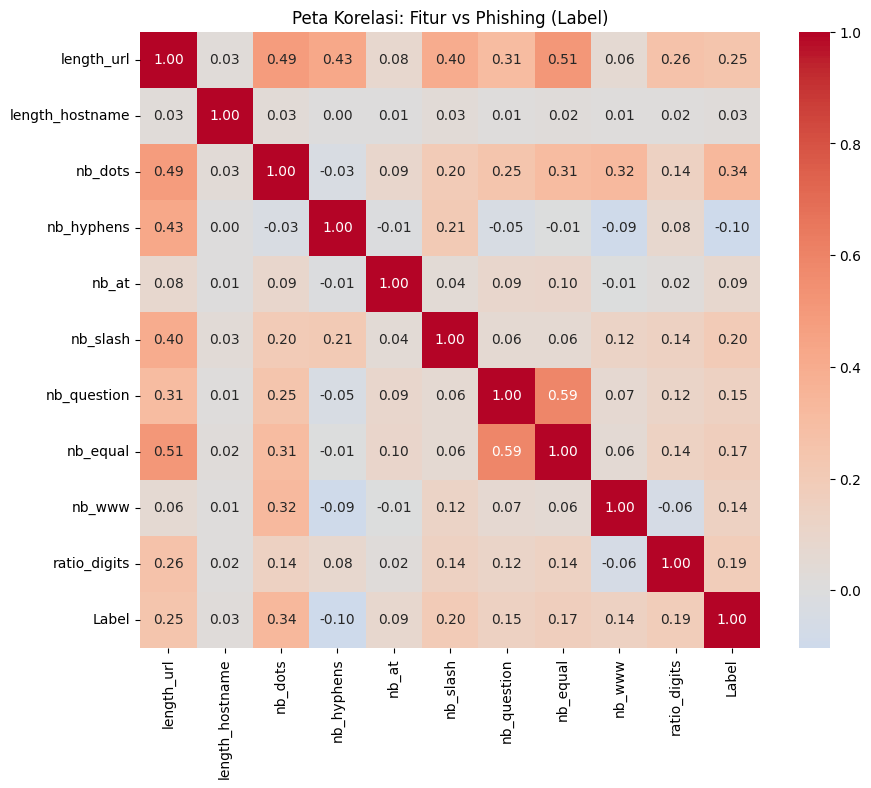

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Hitung Korelasi terhadap Label
korelasi = df_final.corr(method='spearman')['Label'].sort_values(ascending=False)

# 2. Tampilkan Korelasi (Kecuali Label itu sendiri)
print("Top Fitur Paling Berpengaruh (Korelasi terhadap Phishing):")
print(korelasi.drop('Label').head(10))

# 3. Visualisasi Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_final.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Peta Korelasi: Fitur vs Phishing (Label)')
plt.show()

- Analisis distribusi fitur (box plot)

Menganalisis Perbedaan Distribusi Phishing vs Aman...


/tmp/ipython-input-1202463939.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col], x='Label', y=feature, data=df_final, palette='Set2', showfliers=False)
/tmp/ipython-input-1202463939.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col], x='Label', y=feature, data=df_final, palette='Set2', showfliers=False)
/tmp/ipython-input-1202463939.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col], x='Label', y=feature, data=df_final, palette='Set2', showfliers=False)
/tmp/ipython-input-120246393

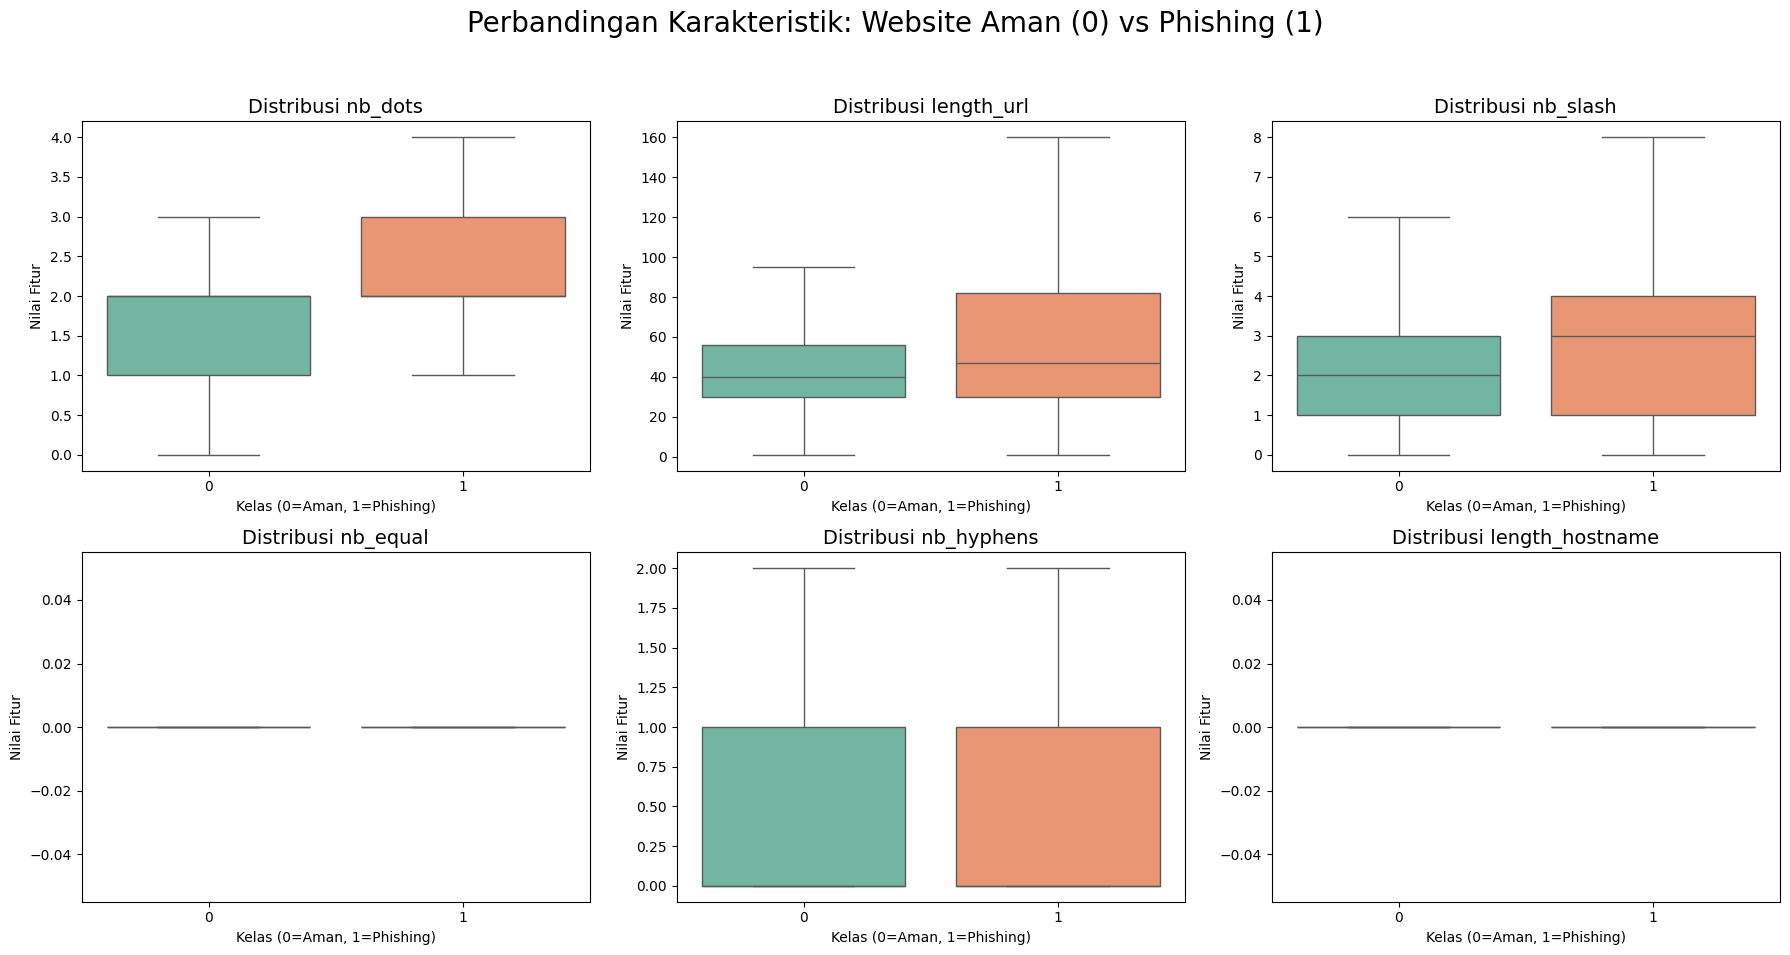

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Menganalisis Perbedaan Distribusi Phishing vs Aman...")

# Kita ambil 6 fitur teratas yang tadi korelasinya paling tinggi
top_features = ['nb_dots', 'length_url', 'nb_slash', 'nb_equal', 'nb_hyphens', 'length_hostname']

# Setup Grid Gambar (2 baris x 3 kolom)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Perbandingan Karakteristik: Website Aman (0) vs Phishing (1)', fontsize=20)

# Loop untuk menggambar setiap fitur
for i, feature in enumerate(top_features):
    row = i // 3
    col = i % 3

    # Gambar Box Plot
    sns.boxplot(ax=axes[row, col], x='Label', y=feature, data=df_final, palette='Set2', showfliers=False)

    axes[row, col].set_title(f'Distribusi {feature}', fontsize=14)
    axes[row, col].set_xlabel('Kelas (0=Aman, 1=Phishing)')
    axes[row, col].set_ylabel('Nilai Fitur')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- Perbaikan fitur

In [14]:
from urllib.parse import urlparse

print("Memperbaiki Bug pada Fitur 'length_hostname'...")

# Fungsi perbaikan cerdas: Kalau tidak ada http, kita tempelkan paksa
def fix_hostname_length(url):
    url = str(url)
    # Jika tidak diawali http/https, tambahkan manual
    if not url.startswith(('http:', 'https:')):
        url = 'http://' + url

    try:
        return len(urlparse(url).netloc)
    except:
        return 0

# Terapkan perbaikan hanya ke kolom yang rusak (ambil URL mentah dari df awal)
# Pastikan variabel 'df' (yang ada kolom 'URL') masih ada di memori
df_final['length_hostname'] = df['URL'].apply(fix_hostname_length)

print("Perbaikan Selesai!")
print("   Sekarang 'length_hostname' sudah berisi angka yang benar.")

# Cek statistik singkat untuk membuktikan tidak 0 lagi
print(df_final['length_hostname'].describe())

Memperbaiki Bug pada Fitur 'length_hostname'...
Perbaikan Selesai!
   Sekarang 'length_hostname' sudah berisi angka yang benar.
count    507196.000000
mean         17.176206
std          11.909125
min           0.000000
25%          12.000000
50%          16.000000
75%          19.000000
max         248.000000
Name: length_hostname, dtype: float64


# STEP 4: FEATURE SELECTION & MODELING

- splitting data (membagi data latih dan data uji)

In [16]:
from sklearn.model_selection import train_test_split

print("Membagi Data untuk Training & Testing...")

# 1. Definisikan Fitur (X) dan Target (y)
X = df_final.drop(columns=['Label']) # Semua angka statistik (Soal)
y = df_final['Label']                # Jawaban (0=Aman, 1=Phishing)

# 2. Lakukan Splitting (80% Latih, 20% Uji)
# random_state=42 menjaga agar kocokan datanya konsisten (reproducible)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Total Data       : {df_final.shape[0]}")
print(f"Data Latih (80%): {X_train.shape[0]} Baris (Untuk Latihan)")
print(f"Data Uji (20%)  : {X_test.shape[0]} Baris (Untuk Uji)")

print("\nSplitting Selesai.")

Membagi Data untuk Training & Testing...
Total Data       : 507196
Data Latih (80%): 405756 Baris (Untuk Latihan)
Data Uji (20%)  : 101440 Baris (Untuk Uji)

Splitting Selesai.


- Seleksi fitur

In [18]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import time

print("Memulai Seleksi Fitur Otomatis (RFE)...")
start_time = time.time()

# 1. Trik Optimasi: Gunakan Sampel Kecil dulu untuk mencari fitur terbaik
X_sample = X_train.sample(n=20000, random_state=42)
y_sample = y_train.loc[X_sample.index]

# 2. Siapkan Model Penyeleksi (Random Forest)
model_selector = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

# 3. Jalankan RFE (Kita minta sisakan 10 Fitur Terbaik)
rfe = RFE(estimator=model_selector, n_features_to_select=10, step=1)
rfe.fit(X_sample, y_sample)

# 4. Ambil Fitur Terpilih
fitur_terpilih = X.columns[rfe.support_]

# 5. Terapkan Seleksi ke Data Asli (Hapus fitur yang tidak terpilih)
X_train_selected = X_train[fitur_terpilih]
X_test_selected = X_test[fitur_terpilih]

print(f"Seleksi Selesai dalam {time.time() - start_time:.2f} detik.")
print(f"10 Fitur Terbaik Pilihan AI:\n{list(fitur_terpilih)}")

print("\n  Dimensi Data Baru (Lebih Ramping):")
print(f"   Train: {X_train_selected.shape}")
print(f"   Test : {X_test_selected.shape}")

Memulai Seleksi Fitur Otomatis (RFE)...
Seleksi Selesai dalam 1.81 detik.
10 Fitur Terbaik Pilihan AI:
['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_slash', 'nb_question', 'nb_equal', 'nb_www', 'ratio_digits']

  Dimensi Data Baru (Lebih Ramping):
   Train: (405756, 10)
   Test : (101440, 10)


- Visualisasi fitur penting

Membuat Grafik Tingkat Kepentingan Fitur...


/tmp/ipython-input-3170251582.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pentingnya', y='Fitur', data=df_importance, palette='viridis')


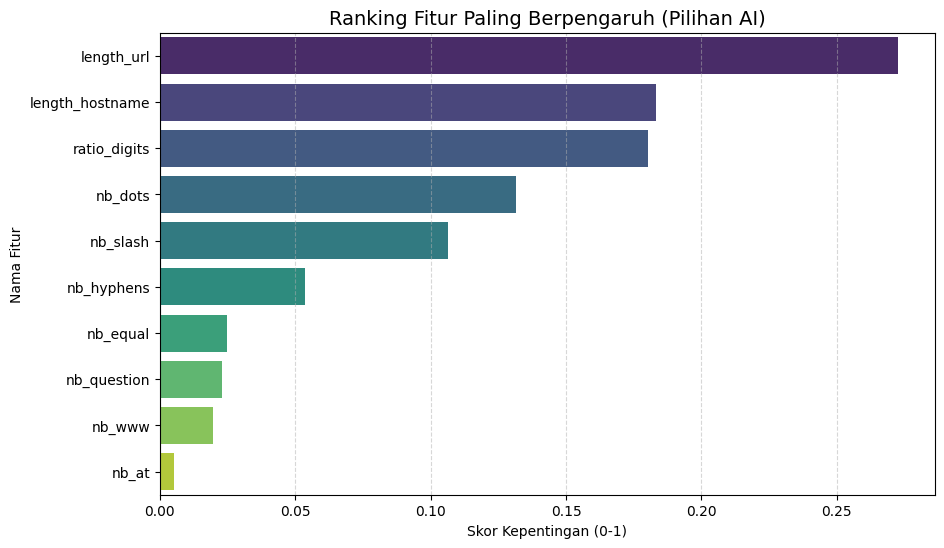

Selesai Sempurna!


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Membuat Grafik Tingkat Kepentingan Fitur...")

# 1. Kita ambil model yang ada di dalam RFE tadi
model_final = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
model_final.fit(X_sample[fitur_terpilih], y_sample)

# 2. Ambil skor "Kepentingan" (Importance)
importances = model_final.feature_importances_

# 3. Buat DataFrame biar rapi
df_importance = pd.DataFrame({
    'Fitur': fitur_terpilih,
    'Pentingnya': importances
}).sort_values(by='Pentingnya', ascending=False)

# 4. Gambar Grafik Batang
plt.figure(figsize=(10, 6))
sns.barplot(x='Pentingnya', y='Fitur', data=df_importance, palette='viridis')

plt.title('Ranking Fitur Paling Berpengaruh (Pilihan AI)', fontsize=14)
plt.xlabel('Skor Kepentingan (0-1)')
plt.ylabel('Nama Fitur')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

print("Selesai Sempurna!")

# STEP 5: MODELING

- Menggabungkan beberapa model

In [22]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import time

print("Sedang melatih 'Super Model' (Stacking Ensemble)...")
print("   (Ini akan memakan waktu 2-5 menit, santai dulu)...")
start_time = time.time()

# 1. Siapkan Para Jenderal (Base Learners)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
]

# 2. Siapkan Komandan Utama (Meta Learner)
meta_learner = LogisticRegression()

# 3. Rakit Model Stacking
clf = StackingClassifier(estimators=estimators, final_estimator=meta_learner)

# 4. Latih Model HANYA dengan 10 Fitur Terpilih (Hasil Step 4)
clf.fit(X_train_selected, y_train)

print(f"\nTRAINING SELESAI dalam {time.time() - start_time:.2f} detik!")
print("Model sudah pintar dan siap diuji.")

Sedang melatih 'Super Model' (Stacking Ensemble)...
   (Ini akan memakan waktu 2-5 menit, santai dulu)...

TRAINING SELESAI dalam 374.30 detik!
Model sudah pintar dan siap diuji.


- Evaluasi model

<>:13: SyntaxWarning: invalid escape sequence '\A'
<>:13: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipython-input-3416129692.py:13: SyntaxWarning: invalid escape sequence '\A'
  print(f"\AKURASI FINAL: {accuracy * 100:.2f}%")


Sedang menguji kecerdasan model dengan Soal Uji (Data Test)...
\AKURASI FINAL: 89.93%

Laporan Detail (Classification Report):
              precision    recall  f1-score   support

    Aman (0)       0.91      0.96      0.94     78736
Phishing (1)       0.84      0.68      0.75     22704

    accuracy                           0.90    101440
   macro avg       0.88      0.82      0.84    101440
weighted avg       0.90      0.90      0.90    101440



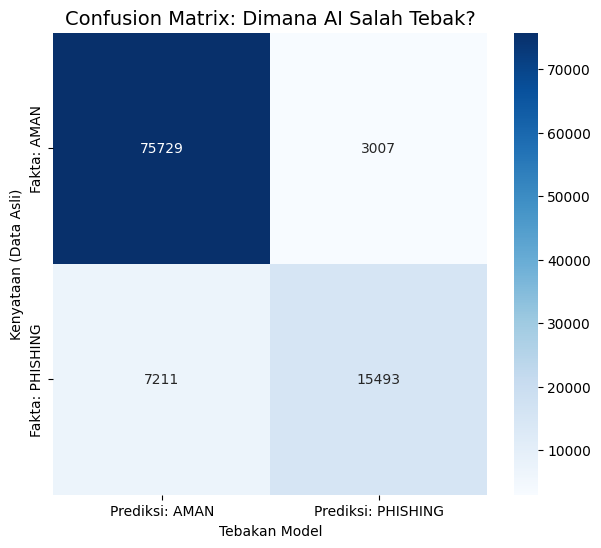

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Sedang menguji kecerdasan model dengan Soal Uji (Data Test)...")

# 1. Ujian Akhir (Prediksi)
# Model mengerjakan 100.000+ soal yang belum pernah dilihat
y_pred = clf.predict(X_test_selected)

# 2. Hitung Nilai Rata-rata (Akurasi)
accuracy = accuracy_score(y_test, y_pred)
print(f"\AKURASI FINAL: {accuracy * 100:.2f}%")

# 3. Rincian Nilai (Laporan Klasifikasi)
print("\nLaporan Detail (Classification Report):")
print(classification_report(y_test, y_pred, target_names=['Aman (0)', 'Phishing (1)']))

# 4. Visualisasi Kesalahan (Confusion Matrix)
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)

# Gambar Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi: AMAN', 'Prediksi: PHISHING'],
            yticklabels=['Fakta: AMAN', 'Fakta: PHISHING'])

plt.title('Confusion Matrix: Dimana AI Salah Tebak?', fontsize=14)
plt.xlabel('Tebakan Model')
plt.ylabel('Kenyataan (Data Asli)')
plt.show()

- Visualisasi kurva ROC - AUC (bukti kestabilan model)

Menggambar Kurva ROC-AUC...


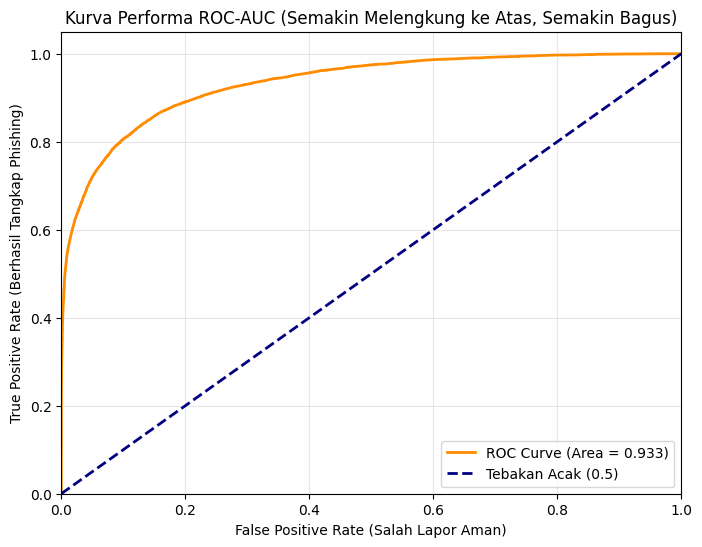

Nilai AUC: 0.933
KESIMPULAN: Model kamu kategori 'Excellent Classification'.


In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

print("Menggambar Kurva ROC-AUC...")

# 1. Minta Probabilitas (Keyakinan) dari Model, bukan sekadar tebakan 0/1
y_prob = clf.predict_proba(X_test_selected)[:, 1]

# 2. Hitung Titik-titik Kurva
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 3. Gambar Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (Area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Tebakan Acak (0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Salah Lapor Aman)')
plt.ylabel('True Positive Rate (Berhasil Tangkap Phishing)')
plt.title('Kurva Performa ROC-AUC (Semakin Melengkung ke Atas, Semakin Bagus)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Nilai AUC: {roc_auc:.3f}")
if roc_auc > 0.9:
    print("KESIMPULAN: Model kamu kategori 'Excellent Classification'.")
else:
    print("KESIMPULAN: Model cukup baik, tapi masih bisa ditingkatkan.")

# STEP 6: UJI COBA REAL-WORLD & DEPLOYMENT

- Uji model dengan beberapa link

In [25]:
import pandas as pd

print("Menguji Model dengan URL Buatan Sendiri...")

# Daftar URL Jebakan (Campuran Asli & Palsu)
urls_to_test = [
    "http://www.google.com",                   # Aman (Jelas)
    "http://secure-login.paypal.com.bca.co.id", # Phishing (Subdomain numpuk)
    "https://netflix-payment-verify.com",      # Phishing (Ada tanda hubung mencurigakan)
    "https://mikroskil.ac.id",                 # Aman (Kampus)
    "http://www.klikbca.com",                  # Aman (Bank)
    "http://0x5a.0x11.0x23.0x44/login"         # Phishing (Pakai IP Address aneh)
]

print(f"\n{'URL':<50} | {'PREDIKSI':<10} | {'STATUS'}")
print("-" * 80)

for url in urls_to_test:
    # 1. Ekstrak fitur dari URL tersebut (Pakai fungsi yang sama dengan saat training)
    features = pd.Series(ekstrak_fitur_url(url))

    # 2. Filter hanya 10 fitur terpilih (Sesuai hasil RFE di Step 4)
    # (Penting: Urutan kolom harus sama persis saat training)
    features_df = pd.DataFrame([features])[fitur_terpilih]

    # 3. Prediksi
    prediksi = clf.predict(features_df)[0]
    probabilitas = clf.predict_proba(features_df)[0][1] # Seberapa yakin dia itu phishing?

    # 4. Tampilkan Hasil
    label = "PHISHING" if prediksi == 1 else "AMAN "
    print(f"{url:<50} | {probabilitas*100:.1f}%     | {label}")

Menguji Model dengan URL Buatan Sendiri...

URL                                                | PREDIKSI   | STATUS
--------------------------------------------------------------------------------
http://www.google.com                              | 6.2%     | AMAN 
http://secure-login.paypal.com.bca.co.id           | 88.8%     | PHISHING
https://netflix-payment-verify.com                 | 64.3%     | PHISHING
https://mikroskil.ac.id                            | 11.9%     | AMAN 
http://www.klikbca.com                             | 6.8%     | AMAN 
http://0x5a.0x11.0x23.0x44/login                   | 90.8%     | PHISHING


- Uji coba model secara real-time

In [26]:
import pandas as pd
import joblib

print("SISTEM DETEKSI PHISHING SIAP!")
print("ketik 'exit' atau 'keluar' untuk berhenti.\n")

while True:
    try:
        # 1. Minta Input User
        print("-" * 60)
        url_input = input("Masukkan Link/URL untuk dicek: ")

        # Cek kondisi berhenti
        if url_input.lower() in ['exit', 'keluar', 'stop']:
            print("Terima kasih. Sesi demo selesai.")
            break

        if not url_input.strip():
            continue # Skip jika kosong

        # 2. Preprocessing (Harus sama persis dengan saat Training)
        fitur_mentah = ekstrak_fitur_url(url_input)

        # Ubah ke DataFrame
        df_input = pd.DataFrame([fitur_mentah])

        # 3. Seleksi Fitur (Hanya ambil 10 fitur yang dikenali model)
        df_final_input = df_input[fitur_terpilih]

        # 4. Prediksi Model
        prediksi_kelas = clf.predict(df_final_input)[0]
        probabilitas = clf.predict_proba(df_final_input)[0][1] * 100 # Persentase Phishing

        # 5. Tampilkan Hasil
        print(f"\nAnalisis AI untuk: {url_input}")
        if prediksi_kelas == 1:
            print(f"KESIMPULAN: BERBAHAYA / PHISHING! (Tingkat Bahaya: {probabilitas:.2f}%)")
            print("   Saran: JANGAN DIKLIK! Ini kemungkinan besar penipuan.")
        else:
            print(f"KESIMPULAN: AMAN (Skor Phishing: {probabilitas:.2f}%)")
            print("   Saran: Website ini terlihat aman secara struktur URL.")

    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
        print("   Pastikan URL valid atau model sudah diload.")

SISTEM DETEKSI PHISHING SIAP!
ketik 'exit' atau 'keluar' untuk berhenti.

------------------------------------------------------------
Masukkan Link/URL untuk dicek: https://www.deepl.com/

Analisis AI untuk: https://www.deepl.com/
KESIMPULAN: AMAN (Skor Phishing: 4.80%)
   Saran: Website ini terlihat aman secara struktur URL.
------------------------------------------------------------
Masukkan Link/URL untuk dicek: https://diskon2025.com/produk-terlaris

Analisis AI untuk: https://diskon2025.com/produk-terlaris
KESIMPULAN: AMAN (Skor Phishing: 6.33%)
   Saran: Website ini terlihat aman secara struktur URL.
------------------------------------------------------------
Masukkan Link/URL untuk dicek: https://klikbca.com.login-bca-indonesia.xyz

Analisis AI untuk: https://klikbca.com.login-bca-indonesia.xyz
KESIMPULAN: AMAN (Skor Phishing: 26.13%)
   Saran: Website ini terlihat aman secara struktur URL.
------------------------------------------------------------
Masukkan Link/URL untuk d

- Simpan model

In [28]:
import joblib

print("Sedang membungkus model ke dalam file...")

# Simpan Model Stacking Utama
joblib.dump(clf, 'model_phishing_stacking.pkl')

# Simpan juga Daftar Nama Fitur (Wajib! Biar kita ingat urutannya nanti)
joblib.dump(fitur_terpilih, 'fitur_terpilih.pkl')

print("BERHASIL! File 'model_phishing_stacking.pkl' sudah tersimpan.")
print("   (Cek panel kiri Colab, download file tersebut untuk cadangan).")

Sedang membungkus model ke dalam file...
BERHASIL! File 'model_phishing_stacking.pkl' sudah tersimpan.
   (Cek panel kiri Colab, download file tersebut untuk cadangan).


- Memanggil model kembali ketika colab di tutup

In [29]:
import joblib
clf = joblib.load('model_phishing_stacking.pkl')
fitur_terpilih = joblib.load('fitur_terpilih.pkl')
print("Model berhasil dimuat kembali!")

Model berhasil dimuat kembali!
